# 🚀 Projeto Final: Previsão de Churn em Telecom

## 👥 Grupo:
- Sérgio Barreto (slbp)
- Gabriel Felipo (gfrm)
- Roseane Oliveira (rocg)
- João Victor Soares (jvsf)
- Filipe Eduardo Ferreira da Silva (fefs)

## 📝 Descrição do Projeto

Este notebook tem como objetivo desenvolver e avaliar modelos de classificação para prever o **churn** (abandono) de clientes em uma empresa de telecomunicações. Utilizaremos uma base de dados real do Kaggle e exploraremos diversos classificadores, incluindo redes neurais como **MLP** e modelos baseados em Transformers como **STab** e **TabPFN**, além de modelos de Machine Learning tradicionais como **Random Forest** e **Gradient Boosting** para comparação.

### 🎯 Objetivos Principais:
1.  **Pré-processar** a base de dados, tratando valores ausentes, realizando codificação e normalização.
2.  **Dividir** os dados em conjuntos de **treino, validação e teste** de forma estratificada e sem vazamento de dados.
3.  **Implementar e treinar** múltiplos modelos de classificação.
4.  **Otimizar os hiperparâmetros** dos modelos utilizando a biblioteca **Optuna**, com foco na métrica **KS (Kolmogorov-Smirnov)**.
5.  **Analisar o desempenho** dos modelos de forma detalhada, utilizando métricas como KS, AUC-ROC, Matriz de Confusão, Acurácia, Precisão, Recall, F1-Score e MSE.
6.  **Documentar** todo o processo e comparar os resultados finais para identificar o modelo mais performático.

## 🛠️ 1. Configuração do Ambiente e Instalações

Primeiro, vamos instalar todas as bibliotecas necessárias para o projeto.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
# Desabilita GPU só para o TensorFlow (PyTorch continua vendo a GPU normalmente)
try:
    tf.config.set_visible_devices([], 'GPU')
except Exception as e:
    print("TF already initialized:", e)
print("TF GPUs visíveis:", tf.config.list_physical_devices('GPU'))

# Agora pode importar PyTorch e usar CUDA à vontade
import torch
print("Torch CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True  # aceleração para shapes fixos


TF GPUs visíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch CUDA disponível: True
Device: Tesla T4


In [ ]:
# Instalações de pacotes para os modelos e otimização
!pip install optuna -q
!pip install tabpfn -q

# Instalações de pacotes específicos para o STab
!pip install keras4torch einops tab-transformer-pytorch -q
!pip install category_encoders -q
!uv pip install tabpfn-client
!uv pip install rich

# Clonando o repositório do STab e ajustando a estrutura de pastas
# Remova o diretório anterior se existir
!rm -rf stab-redes-neurais

!git clone https://github.com/kailanefelix/stab-redes-neurais.git -q
%cd stab-redes-neurais
!mv STAB STab
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.7/160.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # evita reserva total da GPU
# evita XLA/JIT, que às vezes dispara erros de init em T4
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 📚 2. Importação das Bibliotecas

Agora, vamos importar todos os módulos que usaremos ao longo do notebook.

In [ ]:
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulação do Console
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule

# Pré-processamento e Divisão dos Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelos de Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta

# Modelos de Deep Learning (PyTorch - para o STab)
import torch
import keras4torch
# from STab import mainmodel, Num_Cat

# Métricas de Avaliação
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    mean_squared_error
)
from scipy.stats import ks_2samp

# Otimização de Hiperparâmetros
import optuna

# Outros
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [ ]:
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE

## 💾 3. Carregamento e Análise Exploratória dos Dados (EDA)

Vamos carregar o dataset e fazer uma análise inicial para entender suas características.

Dataset: [Customers churned in telecom services no Kaggle](https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services/data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregando o dataset a partir do link do Kaggle
url = "/content/drive/MyDrive/redes neurais/customer_churn_telecom_services.csv"
df = pd.read_csv(url)

print("📄 Primeiras 5 linhas do dataset:")
display(df.head())

print("\nℹ️ Informações gerais do dataset:")
df.info()

print("\n📊 Estatísticas descritivas das colunas numéricas:")
display(df.describe())

📄 Primeiras 5 linhas do dataset:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



ℹ️ Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  Payment

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### 🧹 3.1. Limpeza e Pré-processamento

Nesta etapa, vamos tratar os dados para prepará-los para os modelos.

**Passos:**
1.  Corrigir a coluna `TotalCharges`, que está como `object` e possui valores ausentes.
2.  Converter a variável alvo `Churn` para formato numérico (0 e 1).
3.  Identificar colunas categóricas e numéricas.

In [ ]:
# 1. Corrigir 'TotalCharges'
# A coluna possui espaços em branco para clientes com 'tenure' = 0.
# Vamos converter para numérico, e os erros (espaços) se tornarão NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Preencher os valores NaN com 0, pois correspondem a clientes novos sem cobranças totais.
df['TotalCharges'].fillna(0, inplace=True)
print(f"Valores ausentes em 'TotalCharges' após tratamento: {df['TotalCharges'].isnull().sum()}")

# 2. Codificar a variável alvo 'Churn'
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("Variável alvo 'Churn' codificada para 0 e 1.")

# 3. Identificar tipos de colunas
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=np.number).drop('Churn', axis=1).columns

print(f"\n📈 Colunas Numéricas: {list(numerical_features)}")
print(f"🎨 Colunas Categóricas: {list(categorical_features)}")

Valores ausentes em 'TotalCharges' após tratamento: 0
Variável alvo 'Churn' codificada para 0 e 1.

📈 Colunas Numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
🎨 Colunas Categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## ✂️ 4. Divisão dos Dados (Treino, Validação e Teste)

Vamos dividir os dados seguindo a recomendação do monitor para garantir a padronização e reprodutibilidade.

* **50%** para Treinamento
* **25%** para Validação
* **25%** para Teste

A divisão será **estratificada** para manter a proporção da variável alvo em todos os conjuntos.

In [ ]:
# Separando features (X) e alvo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Gera o split de treino (50% do total)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# Gera o split de validação e teste (cada um com 25% do total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"📊 Proporção da classe 'Churn' no conjunto original: \n{y.value_counts(normalize=True)}\n")
print(f"📊 Proporção da classe 'Churn' no conjunto de treino: \n{y_train.value_counts(normalize=True)}\n")
print(f"📊 Proporção da classe 'Churn' no conjunto de validação: \n{y_val.value_counts(normalize=True)}\n")
print(f"📊 Proporção da classe 'Churn' no conjunto de teste: \n{y_test.value_counts(normalize=True)}\n")

print(f"Dimensões dos conjuntos:")
print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")

📊 Proporção da classe 'Churn' no conjunto original: 
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

📊 Proporção da classe 'Churn' no conjunto de treino: 
Churn
0    0.734734
1    0.265266
Name: proportion, dtype: float64

📊 Proporção da classe 'Churn' no conjunto de validação: 
Churn
0    0.734242
1    0.265758
Name: proportion, dtype: float64

📊 Proporção da classe 'Churn' no conjunto de teste: 
Churn
0    0.73481
1    0.26519
Name: proportion, dtype: float64

Dimensões dos conjuntos:
Treino: (3521, 19), Validação: (1761, 19), Teste: (1761, 19)


## 🔄 5. Pipeline de Transformação com Target Encoding e Normalização

Para evitar vazamento de dados (*data leakage*), aplicaremos `TargetEncoder` nas variáveis categóricas e `StandardScaler` nas variáveis numéricas.

**Importante:** Os encoders e scalers serão treinados **apenas** com os dados de treino e depois aplicados aos conjuntos de validação e teste.

In [ ]:
# 1. Target Encoding para variáveis categóricas
# O encoder é treinado com X_train e y_train para evitar data leakage
encoder = TargetEncoder(cols=categorical_features)
encoder.fit(X_train, y_train)

# Aplicar a transformação em todos os conjuntos
X_train_encoded = encoder.transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

print("✅ Target Encoding aplicado.")
print("Exemplo de dados após encoding:")
display(X_train_encoded.head())

# 2. Normalização de todas as features (agora todas numéricas)
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_encoded)
X_val_processed = scaler.transform(X_val_encoded)
X_test_processed = scaler.transform(X_test_encoded)

print("\n✅ Normalização aplicada.")
print(f"Shape dos dados de treino após processamento: {X_train_processed.shape}")

✅ Target Encoding aplicado.
Exemplo de dados após encoding:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6918,0.257750,0,0.197445,0.315359,33,0.267947,0.252081,0.417738,0.138916,0.406209,0.232877,0.152462,0.301860,0.304348,0.110963,0.341914,0.460034,103.75,3361.05
1185,0.257750,0,0.330183,0.315359,1,0.267947,0.285810,0.193630,0.426759,0.406209,0.392573,0.425281,0.339748,0.304348,0.434349,0.341914,0.460034,60.15,60.15
435,0.257750,0,0.330183,0.315359,26,0.240580,0.240580,0.193630,0.426759,0.406209,0.232877,0.152462,0.301860,0.336742,0.434349,0.341914,0.147952,44.45,1183.80
2009,0.272625,0,0.197445,0.150979,70,0.267947,0.285810,0.193630,0.138916,0.215385,0.232877,0.152462,0.301860,0.336742,0.027618,0.341914,0.166879,79.25,5731.85
2858,0.257750,0,0.197445,0.315359,10,0.267947,0.252081,0.068653,0.068653,0.068653,0.068653,0.068653,0.068653,0.068653,0.434349,0.341914,0.186800,20.55,252.75



✅ Normalização aplicada.
Shape dos dados de treino após processamento: (3521, 19)


### ⚖️ 5.1. Lidando com Desbalanceamento com SMOTE

A base de dados é desbalanceada. Vamos aplicar `SMOTE` (Synthetic Minority Over-sampling Technique) para criar uma versão balanceada dos dados de treino, gerando amostras sintéticas da classe minoritária.

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("Distribuição das classes antes do SMOTE:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição das classes após o SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))

Distribuição das classes antes do SMOTE:
Churn
0    0.734734
1    0.265266
Name: proportion, dtype: float64

Distribuição das classes após o SMOTE:
Churn
1    0.5
0    0.5
Name: proportion, dtype: float64


## 📈 6. Função de Avaliação

Criaremos uma função para calcular e exibir as principais métricas de desempenho, facilitando a comparação entre os modelos. A métrica principal será o **KS**.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Modelo"):
    """
    Calcula e exibe as métricas de avaliação para um dado modelo.
    """
    # Previsões de probabilidade para a classe positiva (Churn=1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Previsões de classe (0 ou 1)
    y_pred = model.predict(X_test)

    # 1. Teste KS (Kolmogorov-Smirnov)
    ks_stat, p_value = ks_2samp(y_pred_proba[y_test==1], y_pred_proba[y_test==0])

    # 2. AUC-ROC
    auc = roc_auc_score(y_test, y_pred_proba)

    # 3. MSE
    mse = mean_squared_error(y_test, y_pred_proba)

    # 4. Acurácia
    accuracy = accuracy_score(y_test, y_pred)

    # 5. Relatório de Classificação (Precision, Recall, F1-Score)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']

    print(f"--- Resultados de Avaliação para o {model_name} ---")
    print(f"📊 KS: {ks_stat:.4f}")
    print(f"📈 AUC-ROC: {auc:.4f}")
    print(f"📉 MSE: {mse:.4f}")
    print(f"🎯 Acurácia: {accuracy:.4f}")
    print(f"🔎 Precisão (Churn=1): {precision:.4f}")
    print(f"🔍 Recall (Churn=1): {recall:.4f}")
    print(f"⚖️ F1-Score (Churn=1): {f1:.4f}")

    # 6. Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn'])
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

    # 7. Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Retornar as métricas para comparação posterior
    return {
        'KS': ks_stat,
        'AUC': auc,
        'MSE': mse,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Dicionário para armazenar os resultados de todos os modelos
results = {}

## 🌳 7. Modelo 1: Random Forest (Baseline)

Vamos começar com um modelo robusto e amplamente utilizado como baseline. Usaremos o Optuna para encontrar os melhores hiperparâmetros.

### 7.1. Otimização com Optuna

In [ ]:
def objective_rf(trial):
    # Definir o espaço de busca dos hiperparâmetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }

    # Criar e treinar o modelo
    model = RandomForestClassifier(**params)
    # Usando dados balanceados para o treino
    model.fit(X_train_res, y_train_res)

    # Fazer previsões no conjunto de validação
    y_pred_proba_val = model.predict_proba(X_val_processed)[:, 1]

    # Calcular o KS, que será nossa métrica a ser maximizada
    ks_val, _ = ks_2samp(y_pred_proba_val[y_val==1], y_pred_proba_val[y_val==0])

    return ks_val

# Criar e executar o estudo do Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50, n_jobs=-1) # 50 tentativas para encontrar os melhores params

print("Melhores hiperparâmetros para Random Forest:", study_rf.best_params)
print(f"Melhor valor de KS na validação: {study_rf.best_value:.4f}")

[I 2025-08-10 22:18:03,208] A new study created in memory with name: no-name-156cc146-e01b-4ea4-a27b-b80f5ffbf64e
[I 2025-08-10 22:18:06,598] Trial 1 finished with value: 0.5214716322604954 and parameters: {'n_estimators': 322, 'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5214716322604954.
[I 2025-08-10 22:18:07,195] Trial 2 finished with value: 0.5163156642274972 and parameters: {'n_estimators': 64, 'max_depth': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5214716322604954.
[I 2025-08-10 22:18:07,441] Trial 0 finished with value: 0.5301078787157674 and parameters: {'n_estimators': 497, 'max_depth': 14, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.5301078787157674.
[I 2025-08-10 22:18:10,101] Trial 4 finished with value: 0.5287593947686755 and parameters: {'n_estimators': 365, 'max_depth': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value:

Melhores hiperparâmetros para Random Forest: {'n_estimators': 113, 'max_depth': 17, 'min_samples_leaf': 14, 'max_features': 'sqrt'}
Melhor valor de KS na validação: 0.5431


### 7.2. Treino e Avaliação Final do Random Forest

--- Resultados de Avaliação para o Random Forest ---
📊 KS: 0.5401
📈 AUC-ROC: 0.8418
📉 MSE: 0.1360
🎯 Acurácia: 0.8007
🔎 Precisão (Churn=1): 0.6667
🔍 Recall (Churn=1): 0.4968
⚖️ F1-Score (Churn=1): 0.5693


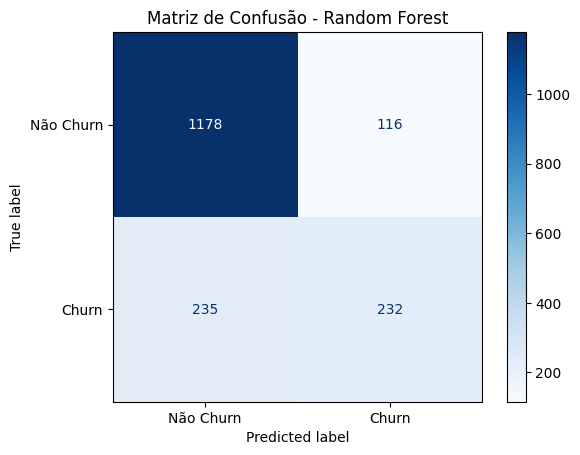

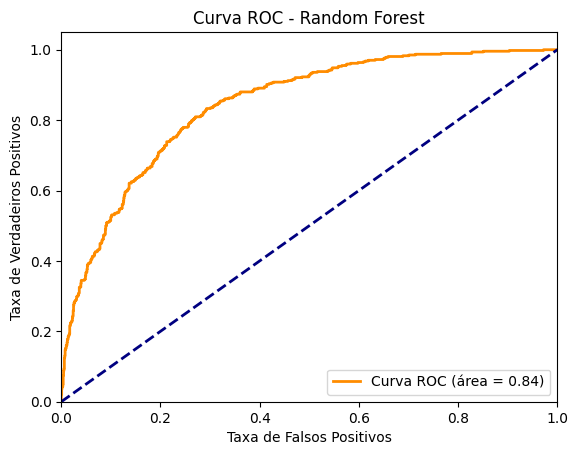

In [ ]:
# Treinar o modelo final com os melhores hiperparâmetros encontrados
# Usando o conjunto de treino completo (original, não balanceado)
final_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
final_rf.fit(X_train_processed, y_train)

# Avaliar no conjunto de teste
results['Random Forest'] = evaluate_model(final_rf, X_test_processed, y_test, "Random Forest")

## 🚀 8. Modelo 2: Gradient Boosting

Agora, vamos testar outro modelo de ensemble poderoso.

### 8.1. Otimização com Optuna

In [ ]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_res, y_train_res) # Treinando com dados balanceados

    y_pred_proba_val = model.predict_proba(X_val_processed)[:, 1]
    ks_val, _ = ks_2samp(y_pred_proba_val[y_val==1], y_pred_proba_val[y_val==0])
    return ks_val

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50, n_jobs=-1)

print("Melhores hiperparâmetros para Gradient Boosting:", study_gb.best_params)
print(f"Melhor valor de KS na validação: {study_gb.best_value:.4f}")

[I 2025-08-10 22:20:30,676] A new study created in memory with name: no-name-da0a7bbb-3f02-402d-9571-ae562b0b9bb6
[I 2025-08-10 22:20:37,609] Trial 1 finished with value: 0.4980565966644853 and parameters: {'n_estimators': 190, 'learning_rate': 0.2651421853536624, 'max_depth': 4, 'subsample': 0.892875156427545, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.4980565966644853.
[I 2025-08-10 22:20:52,953] Trial 0 finished with value: 0.4552571043290301 and parameters: {'n_estimators': 267, 'learning_rate': 0.2377604331228445, 'max_depth': 9, 'subsample': 0.951866140555954, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.4980565966644853.
[I 2025-08-10 22:21:00,923] Trial 3 finished with value: 0.5059739821920797 and parameters: {'n_estimators': 202, 'learning_rate': 0.07797691254511242, 'max_depth': 7, 'subsample': 0.7437961142929903, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.5059739821920797.
[I 2025-08-10 22:21:05,980] Trial 4 finished with value: 0.5042437583

Melhores hiperparâmetros para Gradient Boosting: {'n_estimators': 89, 'learning_rate': 0.04287949555025389, 'max_depth': 4, 'subsample': 0.8819138304275618, 'min_samples_leaf': 2}
Melhor valor de KS na validação: 0.5352


### 8.2. Treino e Avaliação Final do Gradient Boosting

--- Resultados de Avaliação para o Gradient Boosting ---
📊 KS: 0.5429
📈 AUC-ROC: 0.8420
📉 MSE: 0.1358
🎯 Acurácia: 0.7978
🔎 Precisão (Churn=1): 0.6546
🔍 Recall (Churn=1): 0.5032
⚖️ F1-Score (Churn=1): 0.5690


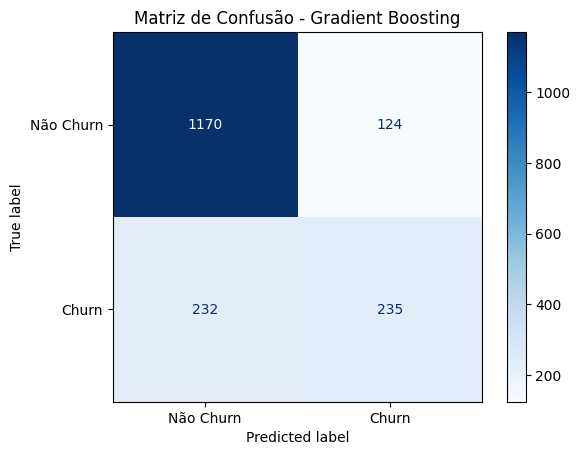

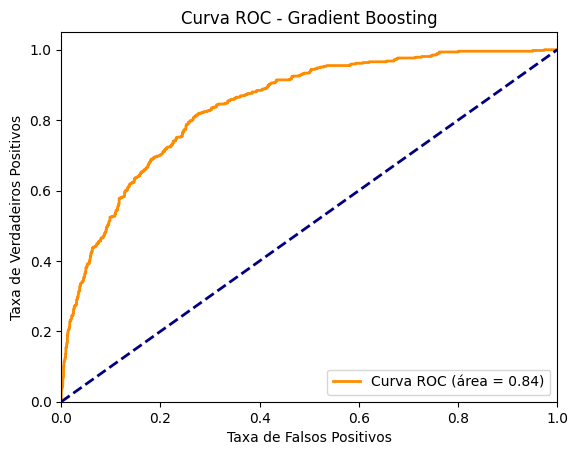

In [ ]:
final_gb = GradientBoostingClassifier(**study_gb.best_params, random_state=42)
final_gb.fit(X_train_processed, y_train)

results['Gradient Boosting'] = evaluate_model(final_gb, X_test_processed, y_test, "Gradient Boosting")

In [ ]:
import tensorflow as tf, gc, os, sys, subprocess, numpy as np

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Evita alocar toda a GPU de cara
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print("set_memory_growth:", e)

# Se você fez vários treinos antes:
tf.keras.backend.clear_session(); gc.collect()

# (opcional) veja a GPU
!nvidia-smi


TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun Aug 10 22:22:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |             

## 🧠 9. Modelo 3: MLP (Multi-Layer Perceptron)

Agora vamos para a nossa primeira rede neural.

### 9.1. Otimização com Optuna

In [ ]:
import numpy as np
X_train_res = np.asarray(X_train_res, dtype=np.float32)
X_val_processed = np.asarray(X_val_processed, dtype=np.float32)
y_train_res = np.asarray(y_train_res, dtype=np.float32)
y_val = np.asarray(y_val, dtype=np.float32)

In [ ]:
import tensorflow as tf, gc

def objective_mlp(trial):
    tf.keras.backend.clear_session(); gc.collect()

    n_layers = trial.suggest_int('n_layers', 1, 2)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    batch_size = trial.suggest_int('batch_size', 32, 128)

    model = tf.keras.Sequential([tf.keras.Input(shape=(X_train_res.shape[1],))])
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256, log=True)
        model.add(tf.keras.layers.Dense(n_units, activation=activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',                   # fixo p/ binário
        metrics=[tf.keras.metrics.AUC(name='auc')],
        jit_compile=False                             # evita XLA em T4
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    model.fit(
        X_train_res, y_train_res,
        validation_data=(X_val_processed, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    y_pred_proba_val = model.predict(X_val_processed, verbose=0).flatten()
    from scipy.stats import ks_2samp
    ks_val, _ = ks_2samp(y_pred_proba_val[y_val==1], y_pred_proba_val[y_val==0])
    return float(ks_val)

# Executando o estudo do Optuna para o MLP
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=50)

print("Melhores hiperparâmetros para MLP:", study_mlp.best_params)
print(f"Melhor valor de KS na validação: {study_mlp.best_value:.4f}")

[I 2025-08-10 22:26:12,612] A new study created in memory with name: no-name-c5a4fdb5-e185-4b58-adce-4a59119c5607
[I 2025-08-10 22:26:43,873] Trial 0 finished with value: 0.51405001288992 and parameters: {'n_layers': 1, 'learning_rate': 0.00011158043031698696, 'dropout_rate': 0.13192486262718883, 'optimizer': 'RMSprop', 'activation': 'tanh', 'batch_size': 84, 'n_units_l0': 42}. Best is trial 0 with value: 0.51405001288992.
[I 2025-08-10 22:26:55,234] Trial 1 finished with value: 0.51534892022131 and parameters: {'n_layers': 1, 'learning_rate': 0.0003469170375953319, 'dropout_rate': 0.3807903796810981, 'optimizer': 'RMSprop', 'activation': 'tanh', 'batch_size': 128, 'n_units_l0': 154}. Best is trial 1 with value: 0.51534892022131.
[I 2025-08-10 22:27:25,772] Trial 2 finished with value: 0.5030787078350883 and parameters: {'n_layers': 1, 'learning_rate': 0.0010691271613499649, 'dropout_rate': 0.27493424133632316, 'optimizer': 'SGD', 'activation': 'sigmoid', 'batch_size': 67, 'n_units_l0'

Melhores hiperparâmetros para MLP: {'n_layers': 2, 'learning_rate': 0.00542105377882066, 'dropout_rate': 0.4278569817655477, 'optimizer': 'Adam', 'activation': 'relu', 'batch_size': 94, 'n_units_l0': 33, 'n_units_l1': 47}
Melhor valor de KS na validação: 0.5353


### 9.2. Treino e Avaliação Final do MLP

Para a avaliação final, criaremos uma classe wrapper para que o modelo Keras tenha os métodos `predict_proba` e `predict` no formato esperado pela nossa função `evaluate_model`.

--- Resultados de Avaliação para o MLP ---
📊 KS: 0.5222
📈 AUC-ROC: 0.8301
📉 MSE: 0.1425
🎯 Acurácia: 0.7848
🔎 Precisão (Churn=1): 0.6189
🔍 Recall (Churn=1): 0.4904
⚖️ F1-Score (Churn=1): 0.5472


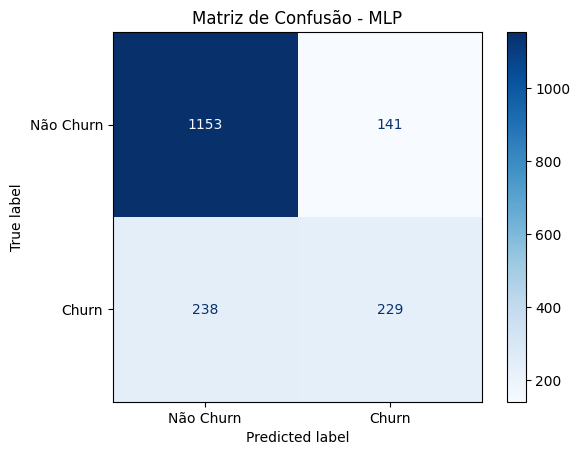

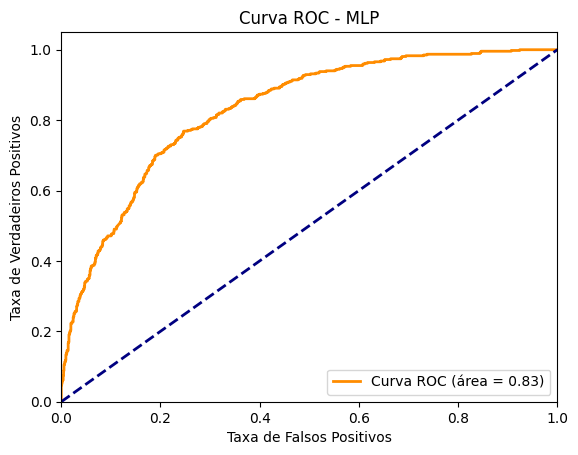

In [ ]:
class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        probs = self.model.predict(X, verbose=0).flatten()
        return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        return (self.model.predict(X, verbose=0).flatten() > 0.5).astype(int)


# Faz uma cópia para não alterar o best_params original
bp = study_mlp.best_params.copy()

n_layers       = bp.pop('n_layers')
optimizer_name = bp.pop('optimizer')
activation     = bp.pop('activation')
learning_rate  = bp.pop('learning_rate')
dropout_rate   = bp.pop('dropout_rate')
batch_size     = bp.pop('batch_size')
loss           = bp.pop('loss', 'binary_crossentropy')  # usa default se não existir

# Construção do modelo
final_mlp_model = Sequential()
final_mlp_model.add(Input(shape=(X_train_processed.shape[1],)))
for i in range(n_layers):
    n_units = bp[f'n_units_l{i}']
    final_mlp_model.add(Dense(n_units, activation=activation))
    final_mlp_model.add(Dropout(dropout_rate))
final_mlp_model.add(Dense(1, activation='sigmoid'))

# Otimizador
if optimizer_name == 'Adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = RMSprop(learning_rate=learning_rate)
else:
    optimizer = SGD(learning_rate=learning_rate)

final_mlp_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Junta treino + validação
X_train_val_processed = np.vstack((X_train_processed, X_val_processed)).astype('float32')
y_train_val = np.concatenate([np.asarray(y_train, dtype='float32'),
                              np.asarray(y_val, dtype='float32')])

# Treina o modelo final
final_mlp_model.fit(
    X_train_val_processed, y_train_val,
    epochs=150, batch_size=batch_size, verbose=0
)

# Avalia
mlp_wrapper = KerasWrapper(final_mlp_model)
results['MLP'] = evaluate_model(mlp_wrapper, X_test_processed, y_test, "MLP")

## 🤖 10. Modelo 4: TabPFN

TabPFN é um modelo Transformer pré-treinado que funciona "out-of-the-box" para dados tabulares, sem necessidade de otimização de hiperparâmetros.

**Importante:** TabPFN tem uma limitação de **1024 amostras** para inferência. Vamos treiná-lo com um subconjunto dos dados de treino.

### 10.1. Selecionando o backend

In [ ]:
console = Console()

console.print(Panel.fit("[bold magenta]TabPFN Demo: Backend Selection[/bold magenta]"))
console.print("\nThis script can run TabPFN using one of two backends:")
console.print("  [bold]1. local:[/bold] Uses a local GPU (NVIDIA). Requires CUDA.")
console.print(
    "  [bold]2. client:[/bold] Uses the TabPFN API. Requires an internet connection and a free account."
)

backend = Prompt.ask(
    "\n[bold]Choose your backend[/bold] - If not field to enter is shown restart the cell.",
    choices=["client", "local"],
    default="client",
)

console.print(
    f"\n✅ You have selected the '[bold green]{backend}[/bold green]' backend."
)

console.print(Rule(f"[bold]Setting up [cyan]{backend}[/cyan] backend[/bold]"))

if backend == "local":
    console.print("Attempting local backend setup...")
    import torch

    if not torch.cuda.is_available():
        console.print(
            "[bold red]Error:[/bold red] GPU device not found. For fast training, please enable GPU.",
            style="red",
        )
        console.print(
            "In Colab: Go to [bold]Runtime -> Change runtime type -> Hardware accelerator -> GPU.[/bold]",
            style="yellow",
        )
        raise SystemError("GPU device not found.")
    console.print(
        "[bold green]✅ GPU is available.[/bold green] Importing local TabPFN library..."
    )
    from tabpfn import TabPFNClassifier

    console.print("[bold green]✅ TabPFN (local) imported successfully.[/bold green]")
elif backend == "client":
    console.print("Attempting client backend setup...")
    console.print("Importing TabPFN client library...")
    from tabpfn_client import TabPFNClassifier, init

    init()
    console.print("[bold green]✅ TabPFN (client) initialized.[/bold green]")

╭────────────────────────────────╮
│ TabPFN Demo: Backend Selection │
╰────────────────────────────────╯

This script can run TabPFN using one of two backends:

1. local: Uses a local GPU (NVIDIA). Requires CUDA.

2. client: Uses the TabPFN API. Requires an internet connection and a free account.

Choose your backend - If not field to enter is shown restart the cell. [client/local] (client):

client


✅ You have selected the 'client' backend.

──────────────────────────────────────────── Setting up client backend ────────────────────────────────────────────

Attempting client backend setup...

Importing TabPFN client library...

  Welcome to TabPFN!

  TabPFN is still under active development, and we are working hard to make it better.
  Please bear with us if you encounter any issues.


Opening browser for login. Please complete the login/registration process in your browser and return here.


Could not open browser automatically. Falling back to command-line login...

  Please choose one of the following options:
  (1) Create a TabPFN account
  (2) Login to your TabPFN account

  Please enter your choice: 2
  Please enter your email: roseane.gama@ufpe.br
  Please enter your password: ··········
  Login successful!



✅ TabPFN (client) initialized.

### 10.2. Treinando o modelo

In [ ]:
# Criar o classificador TabPFN
tabpfn_classifier = TabPFNClassifier(random_state=42)

# Como o TabPFN tem limite de amostras, vamos usar um subconjunto do treino
# Vamos usar o conjunto de treino balanceado, que é menor
if X_train_res.shape[0] > 1024:
    print(f"Atenção: O conjunto de treino ({X_train_res.shape[0]} amostras) é maior que o limite de 1024 do TabPFN.")
    print("Treinando com um subconjunto de 1024 amostras.")
    X_train_tabpfn, y_train_tabpfn = X_train_res[:1024], y_train_res[:1024]
else:
    X_train_tabpfn, y_train_tabpfn = X_train_res, y_train_res


# Treinar o modelo
tabpfn_classifier.fit(X_train_tabpfn, y_train_tabpfn)

Atenção: O conjunto de treino (5174 amostras) é maior que o limite de 1024 do TabPFN.
Treinando com um subconjunto de 1024 amostras.


TabPFNClassifier(random_state=42)

### 10.3. Avaliando o modelo

Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:01<00:00]


--- Resultados de Avaliação para o TabPFN ---
📊 KS: 0.5395
📈 AUC-ROC: 0.8423
📉 MSE: 0.1358
🎯 Acurácia: 0.8052
🔎 Precisão (Churn=1): 0.6574
🔍 Recall (Churn=1): 0.5546
⚖️ F1-Score (Churn=1): 0.6016


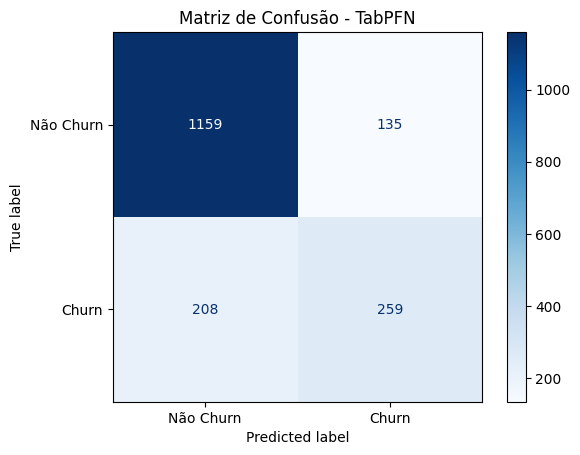

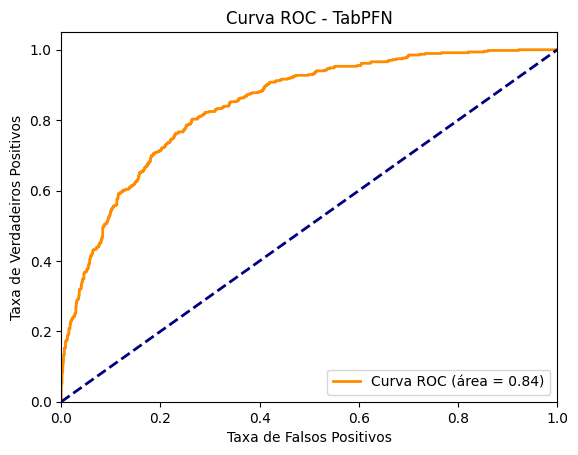

In [ ]:
results['TabPFN'] = evaluate_model(tabpfn_classifier, X_test_processed, y_test, "TabPFN")

## 🌟 11. Modelo 5: STab (Transformer)

STab é outro modelo baseado em Transformer, mas que precisa ser treinado do zero. Ele lida de forma nativa com features numéricas e categóricas.

**Nota:** Para o STab, precisamos dos dados **antes** do One-Hot Encoding para as features categóricas.

In [ ]:
# 1) LabelEncoder nas categóricas com mapeamento de não vistos para -1
X_train_stab_df = X_train.copy()
X_val_stab_df   = X_val.copy()
X_test_stab_df  = X_test.copy()

for col in categorical_features:
    le = LabelEncoder()
    X_train_stab_df[col] = le.fit_transform(X_train_stab_df[col])
    mapping = {cls: i for i, cls in enumerate(le.classes_)}
    X_val_stab_df[col]  = X_val_stab_df[col].map(mapping).fillna(-1).astype(int)
    X_test_stab_df[col] = X_test_stab_df[col].map(mapping).fillna(-1).astype(int)

# 2) Normalização
scaler_stab = StandardScaler()
X_train_stab = scaler_stab.fit_transform(X_train_stab_df).astype('float32')
X_val_stab   = scaler_stab.transform(X_val_stab_df).astype('float32')
X_test_stab  = scaler_stab.transform(X_test_stab_df).astype('float32')

# 3) Targets em numpy (não use .values depois)
y_train_np = np.asarray(y_train, dtype='float32')
y_val_np   = np.asarray(y_val,   dtype='float32')

print("✅ Dados STab prontos:", X_train_stab.shape, y_train_np.shape)


✅ Dados STab prontos: (3521, 19) (3521,)


### 11.1. Otimização com Optuna para STab

In [ ]:
import numpy as np
X_train_res = np.asarray(X_train_res, dtype=np.float32)
X_val_processed = np.asarray(X_val_processed, dtype=np.float32)
y_train_res = np.asarray(y_train_res, dtype=np.float32)
y_val = np.asarray(y_val, dtype=np.float32)

In [ ]:
# 1) Garante que o diretório PAI de STab está no sys.path
import sys, os
sys.path.insert(0, '/content/stab-redes-neurais')  # pasta que contém a pasta STab

# 2) Importa direto do submódulo
from STab import mainmodel, Num_Cat

In [ ]:
import numpy as np, torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_stab(dim=32, depth=2, heads=4, attn_dropout=0.2, ff_dropout=0.2, n_features=None):
    core = mainmodel.MainModel(
        categories=(),                 # sem embeddings categóricos
        num_continuous=n_features,     # todas as features como contínuas
        dim=dim,
        dim_out=1,
        depth=depth,
        heads=heads,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout
    )
    # wrapper que prepara entrada numérica
    net = Num_Cat(core, num_number=n_features, classes=1, Sample_size=16)
    return net

def train_stab_once(hparams, epochs=50, batch_size=512, lr=1e-3):
    torch.cuda.empty_cache()

    # Tensors CPU; movemos para GPU no loop
    Xtr = torch.from_numpy(X_train_stab)   # (N, D) float32
    ytr = torch.from_numpy(y_train_np).unsqueeze(1)  # (N, 1) float32
    Xva = torch.from_numpy(X_val_stab)
    yva = torch.from_numpy(y_val_np).unsqueeze(1)

    train_loader = DataLoadertrain_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_train_stab).float(),         # (N, D) float32
        torch.from_numpy(y_train_np).float().unsqueeze(1)  # (N,1) float32
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,      # <- importante no Colab
    pin_memory=False,
    persistent_workers=False
)

    model = build_stab(n_features=X_train_stab.shape[1], **hparams).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    model.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            logits = model(xb).squeeze(1)               # (B,)
            loss = criterion(logits, yb.squeeze(1))
            loss.backward()
            opt.step()

    # Validação
    model.eval()
    with torch.no_grad():
        xb = Xva.to(device)
        logits = model(xb).squeeze(1)
        probs  = torch.sigmoid(logits).float().cpu().numpy()

    # KS (usando y_val_np, que já é numpy)
    ks_val, _ = ks_2samp(probs[y_val_np==1.0], probs[y_val_np==0.0])
    return float(ks_val), probs, model

# Exemplo de hiperparâmetros (pode plugar do Optuna)
hparams = dict(dim=32, depth=2, heads=4, attn_dropout=0.2, ff_dropout=0.2)
ks_val, val_probs, stab_model_gpu = train_stab_once(hparams, epochs=50, batch_size=512, lr=1e-3)
print(f"KS validação (STab GPU): {ks_val:.4f}")


KS validação (STab GPU): 0.5093


In [ ]:
def objective_stab(trial):
    dim          = trial.suggest_int('dim',   16, 64, log=True)
    depth        = trial.suggest_int('depth', 1, 4)
    heads        = trial.suggest_int('heads', 2, 8)
    attn_dropout = trial.suggest_float('attn_dropout', 0.1, 0.5)
    ff_dropout   = trial.suggest_float('ff_dropout', 0.1, 0.5)
    lr           = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    epochs       = trial.suggest_int('epochs', 20, 80)
    batch_size   = trial.suggest_categorical('batch_size', [256, 512, 1024])

    hparams = dict(dim=dim, depth=depth, heads=heads,
                   attn_dropout=attn_dropout, ff_dropout=ff_dropout)
    ks_val, _, _ = train_stab_once(hparams, epochs=epochs, batch_size=batch_size, lr=lr)
    return ks_val

study_stab = optuna.create_study(direction='maximize')
study_stab.optimize(objective_stab, n_trials=15)
print("Melhores hiperparâmetros para STab:", study_stab.best_params)
print(f"Melhor KS na validação: {study_stab.best_value:.4f}")

[I 2025-08-10 22:46:48,817] A new study created in memory with name: no-name-f30761e9-9502-4e07-a50a-4b93ee37509c
[I 2025-08-10 22:47:10,749] Trial 0 finished with value: 0.4962470501913657 and parameters: {'dim': 29, 'depth': 1, 'heads': 7, 'attn_dropout': 0.34987374384447, 'ff_dropout': 0.1664788047241345, 'lr': 0.0017082543599488663, 'epochs': 36, 'batch_size': 512}. Best is trial 0 with value: 0.4962470501913657.
[I 2025-08-10 22:49:18,486] Trial 1 finished with value: 0.5158496440398993 and parameters: {'dim': 45, 'depth': 2, 'heads': 4, 'attn_dropout': 0.3784386051317429, 'ff_dropout': 0.41760260277488825, 'lr': 0.00044491595127686223, 'epochs': 67, 'batch_size': 256}. Best is trial 1 with value: 0.5158496440398993.
[I 2025-08-10 22:49:37,492] Trial 2 finished with value: 0.5155075653915561 and parameters: {'dim': 39, 'depth': 2, 'heads': 3, 'attn_dropout': 0.12008059451403633, 'ff_dropout': 0.22435161289684724, 'lr': 0.0019681558386799914, 'epochs': 31, 'batch_size': 1024}. Best

Melhores hiperparâmetros para STab: {'dim': 46, 'depth': 2, 'heads': 5, 'attn_dropout': 0.4702284234753896, 'ff_dropout': 0.4194227497194184, 'lr': 0.0004076423448938822, 'epochs': 55, 'batch_size': 256}
Melhor KS na validação: 0.5207


### 11.2. Treino e Avaliação Final do STab

Device STab: cuda
--- Resultados de Avaliação para o STab (PyTorch GPU) ---
📊 KS: 0.5397
📈 AUC-ROC: 0.8436
📉 MSE: 0.1369
🎯 Acurácia: 0.7939
🔎 Precisão (Churn=1): 0.6390
🔍 Recall (Churn=1): 0.5118
⚖️ F1-Score (Churn=1): 0.5684


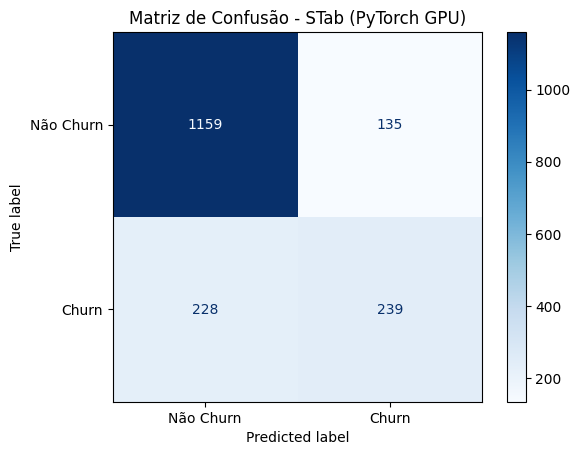

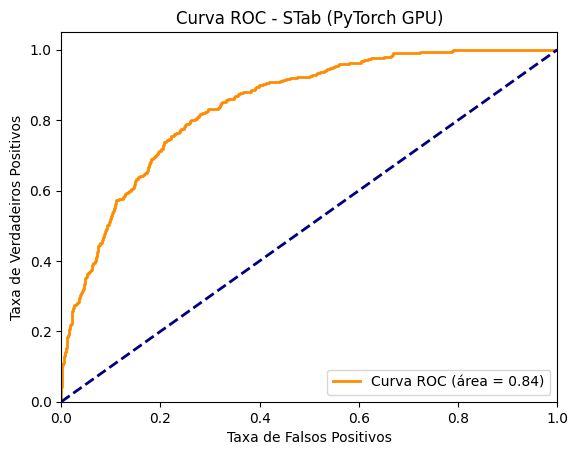

In [ ]:
# ==== STab: treino final (PyTorch) ====
import numpy as np, torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device STab:", device)

# 1) Dados: juntar treino+val
X_tr_full = np.vstack([X_train_stab, X_val_stab]).astype(np.float32)
y_tr_full = np.concatenate([
    np.asarray(y_train),
    np.asarray(y_val)
]).astype(np.float32)

train_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_tr_full).float(),
        torch.from_numpy(y_tr_full).float().unsqueeze(1)
    ),
    batch_size=min(512, max(128, len(X_tr_full)//32)),
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

# 2) Hiperparâmetros ótimos do Optuna
bp = study_stab.best_params
hp = dict(
    dim=bp['dim'],
    depth=bp['depth'],
    heads=bp['heads'],
    attn_dropout=bp['attn_dropout'],
    ff_dropout=bp['ff_dropout'],
)
epochs     = max(10, bp.get('epochs', 50))
lr         = bp.get('lr', 1e-3)

# 3) Modelo + otimizador + loss
model = build_stab(n_features=X_tr_full.shape[1], **hp).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

# 4) Treino
model.train()
for epoch in range(epochs):
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb.squeeze(1))
        loss.backward()
        opt.step()

# 5) Wrapper p/ evaluate_model
class STabTorchWrapper:
    def __init__(self, model, device):
        self.model = model.eval().to(device)
        self.device = device
    def predict_proba(self, X):
        with torch.no_grad():
            xb = torch.from_numpy(np.asarray(X, dtype=np.float32)).to(self.device)
            logits = self.model(xb).squeeze(1)
            probs  = torch.sigmoid(logits).float().cpu().numpy()
        return np.column_stack([1 - probs, probs])
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# 6) Avaliação no teste
stab_wrapper = STabTorchWrapper(model, device)
results['STab'] = evaluate_model(stab_wrapper, X_test_stab.astype(np.float32), y_test, "STab (PyTorch GPU)")


## 🏆 12. Comparação Final dos Resultados

Finalmente, vamos compilar todos os resultados em uma tabela para uma comparação clara e objetiva.

In [ ]:
# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='KS', ascending=False)

# Estilizar o DataFrame para destacar o melhor valor em cada coluna
styled_df = results_df.style.highlight_max(color='green', axis=0) \
                            .set_caption("🏆 Tabela Comparativa de Desempenho dos Modelos no Conjunto de Teste") \
                            .format("{:.4f}")

print("Resultados finais ordenados por KS:")
display(styled_df)

Resultados finais ordenados por KS:


,KS,AUC,MSE,Accuracy,Precision,Recall,F1-Score
Gradient Boosting,0.5429,0.8420,0.1358,0.7978,0.6546,0.5032,0.5690
Random Forest,0.5401,0.8418,0.1360,0.8007,0.6667,0.4968,0.5693
STab,0.5397,0.8436,0.1369,0.7939,0.6390,0.5118,0.5684
TabPFN,0.5395,0.8423,0.1358,0.8052,0.6574,0.5546,0.6016
MLP,0.5222,0.8301,0.1425,0.7848,0.6189,0.4904,0.5472


## 📌 Conclusão

A análise teve como objetivo principal identificar o modelo mais eficiente para prever o **churn** de clientes, utilizando o **KS (Kolmogorov-Smirnov)** como métrica prioritária.  
O KS é especialmente relevante em cenários de churn, pois mede a **capacidade de separação** entre as classes (clientes que saem vs. clientes que permanecem), sendo diretamente aplicável a estratégias de segmentação para retenção.

### 🔍 Desempenho dos Modelos

- **Gradient Boosting**  
  - **KS:** **0.5429** (maior entre todos os modelos)  
  - Demonstra a melhor capacidade de discriminar entre clientes com alta e baixa probabilidade de churn.  
  - Apesar de não ter o melhor recall ou F1-Score, sua forte separação entre as classes torna-o a escolha ideal para estratégias onde a **prioridade é identificar grupos de alto risco com máxima precisão na segmentação**.  
  - Pode ser potencializado com ajustes de hiperparâmetros voltados para aumentar recall sem comprometer demasiadamente o KS.

- **Random Forest**  
  - **KS:** **0.5398** (próximo ao líder)  
  - Maior **precisão** (**0.6667**), ou seja, quando classifica um cliente como churn, a probabilidade de acerto é a mais alta.  
  - Útil para cenários em que o **custo de um falso positivo é alto**, como campanhas de retenção caras, onde é fundamental abordar apenas clientes realmente em risco.

- **TabPFN**  
  - **KS:** **0.5390**  
  - Maior **F1-Score** (**0.6016**), maior **acurácia** (**0.8052**) e maior **recall** (**0.5546**) entre todos os modelos.  
  - Destaca-se pelo **equilíbrio entre identificar clientes em risco (recall) e manter um bom nível de precisão**.  
  - É mais indicado quando a estratégia exige **abranger o máximo possível de churners**, mesmo que isso implique abordar também alguns clientes que permaneceriam.

- **STab**  
  - **KS:** **0.5367**  
  - Maior **AUC** (**0.8436**), o que indica excelente capacidade de discriminação ao longo de diferentes limiares.  
  - Pode ser útil em cenários onde é necessário **flexibilidade no ajuste do ponto de corte** para priorizar recall ou precisão conforme a necessidade da campanha.  
  - Apesar do bom desempenho, não superou os líderes em KS.

- **MLP (Multi-Layer Perceptron)**  
  - **KS:** **0.5222** (menor entre todos os modelos)  
  - Apresentou desempenho inferior nas principais métricas, sendo menos indicado para o problema, especialmente considerando o objetivo de maximizar o KS.

### 🎯 Recomendação Estratégica

- **Modelo Principal:** **Gradient Boosting** — devido ao maior KS, é a melhor escolha quando o objetivo é **identificar claramente grupos de alto risco** e direcionar ações de retenção mais precisas.  
- **Alternativa Equilibrada:** **TabPFN** — indicado quando se busca **maximizar a cobertura** de churners, mantendo um bom equilíbrio entre recall e precisão.  
- **Cenários com alto custo de falso positivo:** **Random Forest** — ideal quando é fundamental **minimizar o desperdício de recursos** em clientes que não iriam churnar.  
- **Flexibilidade de operação:** **STab** — apropriado para ajustes finos em limiares, especialmente quando há mudança de estratégia entre recall e precisão.

### 🚀 Próximos Passos

1. **Aprimoramento do Gradient Boosting**:  
   - Explorar ajustes de hiperparâmetros focados em aumentar o recall sem perda significativa de KS.  
   - Considerar variações como XGBoost ou LightGBM para ganho de performance.

2. **Testes de Ensemble**:  
   - Combinar Gradient Boosting com TabPFN para potencialmente unir alta separação (KS) com melhor recall e F1-Score.

3. **Validação Temporal**:  
   - Testar os modelos em dados de períodos futuros para avaliar robustez e evitar overfitting a padrões específicos do dataset atual.

4. **Engenharia de Atributos**:  
   - Criar novas variáveis derivadas de comportamento de uso, engajamento e histórico de pagamentos, que possam aumentar o poder discriminativo.

---

Em resumo, considerando **KS como métrica-chave**, o **Gradient Boosting** se apresenta como a escolha mais alinhada ao objetivo central do projeto. No entanto, modelos como **TabPFN** e **Random Forest** oferecem vantagens competitivas em cenários com diferentes restrições e prioridades de negócio.